# Ported code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal

In [2]:
%matplotlib inline

### Path to data

In [3]:
r_file_path = "D:\\MasterData\\TilEmil\\CarotidData\\12-Apr-2018\\13_34_57\\bf\\LowResBFdata_point1_1_r"
i_file_path = "D:\\MasterData\\TilEmil\\CarotidData\\12-Apr-2018\\13_34_57\\bf\\LowResBFdata_point1_1_i"

### Creating structs

In [4]:
bfPars =	{
    "f_demod": 4750000.0,
    "bandPassVec": np.array([2000000.0,2200000.0,7300000.0,7400000.0]),
    "c": 1540.0,
    "txVals": np.array([-2.618,-2.618,-2.618,-2.618,-2.618,2.618,2.618,2.618,2.618]),
    "rxVals": np.array([-2.618,-0.0611,0.1047,0.2618,0,-0.1047,0.0611,0.2618,0]),
    "PRF": 6000,
    "lowResRxApodDop": 'hamming',
    "lowResRxApodBmode": 'hamming',
    "lowResRxFnumDop": 1.5,
    "lowResRxFnumBmode": 0.9,
    "nrEdgeSmoothingElementsDop": 20,
    "nrEdgeSmoothingElementsBmode": 20,
    "probe": 'GE9L-D',
    "x_axis": np.linspace(start=-0.219,stop=0.219,num=274),
    "z_axis": np.linspace(start=0.000646, stop=0.03, num=184)
}


# class Params:
#     a = 0
#     b = 10
    
    
# Params.a

# Not complete, need a way to fill the x_axis and z_axis, not sure what values are in there. Do we need it if it is just the data?

In [5]:
print(bfPars["z_axis"])

[0.000646   0.0008064  0.00096681 0.00112721 0.00128762 0.00144802
 0.00160843 0.00176883 0.00192923 0.00208964 0.00225004 0.00241045
 0.00257085 0.00273126 0.00289166 0.00305207 0.00321247 0.00337287
 0.00353328 0.00369368 0.00385409 0.00401449 0.0041749  0.0043353
 0.0044957  0.00465611 0.00481651 0.00497692 0.00513732 0.00529773
 0.00545813 0.00561854 0.00577894 0.00593934 0.00609975 0.00626015
 0.00642056 0.00658096 0.00674137 0.00690177 0.00706217 0.00722258
 0.00738298 0.00754339 0.00770379 0.0078642  0.0080246  0.00818501
 0.00834541 0.00850581 0.00866622 0.00882662 0.00898703 0.00914743
 0.00930784 0.00946824 0.00962864 0.00978905 0.00994945 0.01010986
 0.01027026 0.01043067 0.01059107 0.01075148 0.01091188 0.01107228
 0.01123269 0.01139309 0.0115535  0.0117139  0.01187431 0.01203471
 0.01219511 0.01235552 0.01251592 0.01267633 0.01283673 0.01299714
 0.01315754 0.01331795 0.01347835 0.01363875 0.01379916 0.01395956
 0.01411997 0.01428037 0.01444078 0.01460118 0.01476158 0.01492

### Reading data, reshaping into a [184, 274, 9, 270] Matrix.

In [6]:
low_res_data_array = np.fromfile(r_file_path,np.float32,-1)+1j*np.fromfile(i_file_path,np.float32,-1)
low_res_data = low_res_data_array.reshape(184, 274, 9, 270,order='F')

### Filling variables

In [7]:
nAngles = bfPars["rxVals"].size
print(nAngles)
# TODO: Find out if the index below is correct, in matlab it is 1-3
start_frame = 1 
end_frame = 3
num_saved_frames = end_frame - start_frame +1 # ???


9


### Hack to look at data - find interesting frame


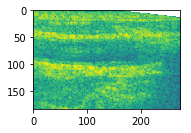

In [8]:
plt.subplot(2,1,1)
# TODO: Find out if parameters are correct
to_plot = 20*np.log10(np.absolute(np.squeeze(low_res_data[:,:,4,99])))
plt.imshow(to_plot)

#### Here it selects a frame for inspection, is this needed?

In [9]:
t_look = 1.2
t_start = start_frame*270/bfPars["PRF"] # 270 Hard coded for now
print(t_start)
t = t_look - t_start
print(t)
f_look = t*bfPars["PRF"]
print(f_look)

0.045
1.155
6930.0


### Sliding window, processing parameters

In [10]:
process_packet = 270
skip = 20

In [11]:
nr_lr_frames = low_res_data.shape[3]
# nr_lr_frames = 810 # For debugging

In [12]:
# The +1 at stop is not in matlab, but needed in python to get the same size
max_num_process_packets = np.arange(start=process_packet/2,stop=(nr_lr_frames-process_packet/2)+1, step=skip).size
print(max_num_process_packets)

1


In [13]:
# TODO: Find out if this should be 1, as it is in Matlab
start_packet = 0 

In [14]:
nr_packets = 1

There is created a struct in matlab with processPacket, skip and vdtime. Is this needed?

In [15]:
procParams = 	{
    "process_packet": process_packet,
    "skip": skip,
    # Removed -1 from max_num_process_packets
    "vd_time": (np.arange(start=process_packet/2, stop=skip*(max_num_process_packets)+(process_packet/2), step=skip)) / bfPars["PRF"]
}
print(procParams["vd_time"])
# ((processPacket/2):skip:skip*(maxNumProcessPackets-1)+(processPacket/2))/bfPars.PRF# 

[0.0225]


In [16]:
print(procParams["vd_time"].size)

1


In [109]:
filter_b = np.array([0.013974507740562,  -0.004610553690858,  -0.003959583887660,  -0.003421437717813,  -0.002960559310507,  -0.002546987603092,  -0.002152407693477,  -0.001752369109738,  -0.001335666591534,  -0.000886985569956,
                    -0.000406397631234, 0.000105239633353, 0.000636228776527, 0.001171627782228, 0.001691442937575, 0.002171473383531, 0.002586613469418, 0.002909053988966,  0.003114143802294, 0.003178699822964, 0.003086226298184,
                     0.002825822207217, 0.002394929610520, 0.001799244313407, 0.001053101010350, 0.000180580071057, -0.000786262822472, -0.001805922295758, 0.002831500727849,-0.003809890804760,
                    -0.004687127561322, -0.005408537732333, -0.005923021230674, -0.006185023274673, -0.006155931408084, -0.005809908523186, -0.005131231888127, -0.004123857624046, -0.002803648953984, -0.001207644615326,
                     0.000614581185567, 0.002598863723559, 0.004660609482286, 0.006719040134487, 0.008639305794054, 0.010372033472662, 0.011759174363705, 0.012712332141398, 0.013147237722652, 0.012976492549904,
                     0.012124612380978, 0.010533980201414, 0.008197019674078, 0.005103604492666, 0.001282897291549, -0.003220624315483, -0.008330358995150, -0.013945505108362, -0.019943186225561, -0.026180338307836,
                    -0.032504133383748, -0.038751252020856, -0.044758360378768, -0.050362088368919, -0.055407601522240, -0.059751812084099, -0.063269556969409, -0.065858778396590, -0.067443137132184, 0.932023291287906,
                    -0.067443137132184, -0.065858778396590, -0.063269556969409, -0.059751812084099, -0.055407601522240, -0.050362088368919, -0.044758360378768, -0.038751252020856, -0.032504133383748, -0.026180338307836, 
                    -0.019943186225561, -0.013945505108362, -0.008330358995150, -0.003220624315483, 0.001282897291549, 0.005103604492666, 0.008197019674078, 0.010533980201414, 0.012124612380978, 0.012976492549904, 
                     0.013147237722652,  0.012712332141398,  0.011759174363705,  0.010372033472662, 0.008639305794054, 0.006719040134487, 0.004660609482286, 0.002598863723559, 0.000614581185567, -0.001207644615326,
                    -0.002803648953984, -0.004123857624046, -0.005131231888127, -0.005809908523186, -0.006155931408084, -0.006185023274673, -0.005923021230674, -0.005408537732333, -0.004687127561322, -0.003809890804760,
                    -0.002831500727849, -0.001805922295758, -0.000786262822472,  0.000180580071057, 0.001053101010350, 0.001799244313407,  0.002394929610520, 0.002825822207217, 0.003086226298184, 0.003178699822964,
                     0.003114143802294,  0.002909053988966, 0.002586613469418, 0.002171473383531,  0.001691442937575, 0.001171627782228, 0.000636228776527, 0.000105239633353, -0.000406397631234,-0.000886985569956,
                    -0.001335666591534, -0.001752369109738, -0.002152407693477, -0.002546987603092, -0.002960559310507, -0.003421437717813, -0.003959583887660, -0.004610553690858, 0.013974507740562])


import scipy.io as spio
filter_b = spio.loadmat('b_filter.mat')['b'][0]


In [133]:
# What does fctr stand for? Frame Counter variable
fctr = 1
# TODO: Find out if for kk = 1:1:nrPackets only happens once, if so skip the loop
for kk in range(0,nr_packets):
    packet_data = low_res_data[:,:,:,process_packet*kk:(process_packet*kk)+process_packet]
    # Some settings
    show_compounded_frames = 0 # Figure displaying all "B-mode" frames??
    show_highpass_frames = 0   # Figure displaying all frames used for speckle tracking (after high pass filtering)
    use_median_filter = 1
    
    # Do you want the full aliasing correction procedure, or only simple least squares algorithm?
    do_aliasing_correction = 0
    
    if nr_packets < max_num_process_packets:
        save_for_movie = 0
    else:
        save_for_movie = 1
        print("Saving data for later use")
    
    # Beamforming parameters
    
    # Doppler ROI 
    use_max_ROI = 0 # If both options are 0, interactively chose ROI. (?)
    use_trapezoid_ROI = 0
    
    # TODO: There is a switch condition here, find out if this is needed. For now, only carotid will be implemented
    max_ROI_depth = 0.032
    min_ROI_depth = 0.005
    
    # Color Doppler/vector Doppler settings
    drop_samples = 1 # For R1 estimation, avoid clutter filter edge effects
    power_threshold_after_hp = 23 # TODO: Remove hard coding
    
    # Specle tracking options
    use_corr_threshold = 1
    correlation_threshold = 0.1
    
    # Angle vectors
    tx_angles = bfPars["txVals"]
    rx_angles = bfPars["rxVals"]
    
    # Filter specs
    pre_c_data = packet_data[:,:,rx_angles==0,:]
    recons_comp_data = pre_c_data.sum(axis=2) # This changes the shape to a 3D matrix, think it still works, but need further testing
    
    rem_inds = np.array([4,8]) # Rem_inds need to be one lower than in matlab due to indexing
    tx_angles = np.delete(tx_angles, rem_inds)
    rx_angles = np.delete(rx_angles, rem_inds)
    
    l = list(range(9))
    del l[8],l[4]
    
    packet_data = packet_data[:,:,l]

    low_res_R0_hp_mat = np.zeros([packet_data.shape[0], packet_data.shape[1], rx_angles.size])
    
    for ii in range(0,rx_angles.size):
        #rx_angles.size):
        squeezed_arr = np.squeeze(packet_data[:,:,ii,:]) # Not sure if this does what I want
        
        transposed_arr = np.transpose(np.asfortranarray(squeezed_arr), (2,0,1))
#         transposed_arr = np.transpose(np.expand_dims(squeezed_arr, axis=1), (2,0,1))
#         print(transposed_arr[0,0,0]) # The ordering is most likely wrong
        
        # Filtering
#         print(transposed_arr[138:149,0,0])

        filtered_arr = signal.lfilter(filter_b, 1, transposed_arr, axis=0)
        np.set_printoptions(linewidth=50,suppress=True)
        
        removed_arr = filtered_arr[filter_b.size-1:,:,:]
        temp = np.transpose(np.asfortranarray(removed_arr), (1,2,0))
        
        low_res_R0_hp_mat[:,:,ii] = np.mean(np.conj(temp)*temp, axis=2)
        # There is an eval statement in the Matlab code, ask about this
                

Saving data for later use


C:\Users\ebras\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\ebras\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


### Clutter filter compounded data, this should be in the kk loop

In [157]:
transposed_arr2 = np.transpose( np.expand_dims(np.asfortranarray(recons_comp_data[:,:,0:]), axis=2), (3,0,1,2) )


(184, 274, 270)
[ 2790.1118 +9082.879j   3903.073  +7123.8115j
  6665.098  +5192.8j    11297.865  +4996.86j
 15255.679  +5234.141j  16063.222  +6602.0186j
 13366.822  +9439.152j   9156.556 +13672.815j
  3486.4292+17712.393j  -2099.4375+16031.189j ]


In [155]:
print(transposed_arr2.shape)
print(transposed_arr[0:10,0,0,0])

(270, 184, 274, 1)
[2790.1118+9082.879j 2790.767 +9081.369j
 2793.0764+9082.042j 2793.2158+9081.645j
 2792.9065+9081.942j 2792.896 +9082.783j
 2793.8123+9082.689j 2795.2468+9081.352j
 2794.0083+9081.384j 2794.357 +9081.821j]


In [158]:
squeezed_arr2 = np.squeeze(transposed_arr2)

In [160]:
print(squeezed_arr2.shape)
print(squeezed_arr2[0:10,0,0])

(270, 184, 274)
[2790.1118+9082.879j 2790.767 +9081.369j
 2793.0764+9082.042j 2793.2158+9081.645j
 2792.9065+9081.942j 2792.896 +9082.783j
 2793.8123+9082.689j 2795.2468+9081.352j
 2794.0083+9081.384j 2794.357 +9081.821j]


In [189]:
iq_hp_comp = signal.lfilter(filter_b, 1, squeezed_arr2, axis=0)
iq_hp_comp = iq_hp_comp[filter_b.size-1:,:,:]
print(iq_hp_comp.shape)
print(iq_hp_comp[0:10,0,0])

(132, 184, 274)
[-0.75158672-2.00833755j  0.319039  -2.42087779j
 -0.05018679-1.57653077j -1.48603259-0.97709339j
  0.29906093-0.65927882j -0.96252274-1.59972159j
 -1.40701823-2.56837567j -1.64413379-2.17928661j
  0.19822229-2.13897628j  0.32841654-1.19427455j]


C:\Users\ebras\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [190]:
iq_hp_comp = np.transpose( np.expand_dims(np.asfortranarray(iq_hp_comp), axis=3), (1,2,3,0) )
print(iq_hp_comp.shape)
print(iq_hp_comp[0:10,0,0,0])

(184, 274, 1, 132)
[-0.75158672-2.00833755j -1.33259825-1.79859585j
 -2.39530638-1.64299107j -3.37236512-2.0989574j
 -3.48636662-2.33218877j -3.36673601-1.64472933j
 -2.24126102-2.0101775j  -2.32052998-2.08946137j
 -1.19500597-3.04755554j  0.22053803-2.56425786j]


In [191]:
max_iq_hp = np.max(np.abs(iq_hp_comp))
print(max_iq_hp)

266.5121266159823


In [192]:
max_iq = np.max(np.abs(recons_comp_data))
print(max_iq)

156859.58


In [205]:
print(iq_hp_comp.shape)
r0_test = 10*np.log10((np.mean(np.abs(iq_hp_comp)**2,axis=3)))
r0_test = np.squeeze(r0_test)
print(r0_test.shape)
print(ro_test[0:10,0])

(184, 274, 1, 132)
(184, 274)
[[ 6.39660037]
 [ 5.52042926]
 [ 5.98430473]
 [ 8.40369592]
 [10.36452768]
 [11.02899965]
 [10.67641019]
 [10.82401749]
 [11.57332919]
 [10.73325998]]
